In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Exercice 1

In [5]:

# Fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

# Extract features and target
X = heart_disease.data.features 
y = heart_disease.data.targets 


In [8]:
# Let's examine the structure of y
print("Structure of target variable:")
print(y.head())
print("\nColumns in target variable:")
print(y.columns)


   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  
Structure of target variable:
   num
0    0
1    2
2    1
3    0
4    0

Columns in target variable:
Index(['num'], dtype='object')


In [9]:

# Convert target to binary (0 for healthy, 1 for sick)
y['num'] = (y['num'] > 0).astype(int)


/var/folders/kp/ksnwmywj77sb5842vcdfqwg40000gn/T/ipykernel_37929/1421367931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['num'] = (y['num'] > 0).astype(int)


In [10]:

# Basic variable descriptions
variable_descriptions = {
    'age': 'Age in years',
    'sex': 'Gender (1 = male; 0 = female)',
    'cp': 'Chest pain type (1-4)',
    'trestbps': 'Resting blood pressure (mm Hg)',
    'chol': 'Serum cholesterol (mg/dl)',
    'fbs': 'Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)',
    'restecg': 'Resting ECG results (0-2)',
    'thalach': 'Maximum heart rate achieved',
    'exang': 'Exercise induced angina (1 = yes; 0 = no)',
    'oldpeak': 'ST depression induced by exercise relative to rest',
    'slope': 'Slope of the peak exercise ST segment',
    'ca': 'Number of major vessels colored by fluoroscopy (0-3)',
    'thal': 'Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect)'
}


In [12]:

# Check correlations with target
correlations = pd.DataFrame()
for col in X.columns:
    correlations.loc[col, 'correlation'] = X[col].corr(y['num'])


In [13]:

print("\nCorrelations with target variable:")
print(correlations.sort_values('correlation', ascending=False))


Correlations with target variable:
          correlation
thal         0.525689
ca           0.460442
exang        0.431894
oldpeak      0.424510
cp           0.414446
slope        0.339213
sex          0.276816
age          0.223120
restecg      0.169202
trestbps     0.150825
chol         0.085164
fbs          0.025264
thalach     -0.417167


## Exercice 2

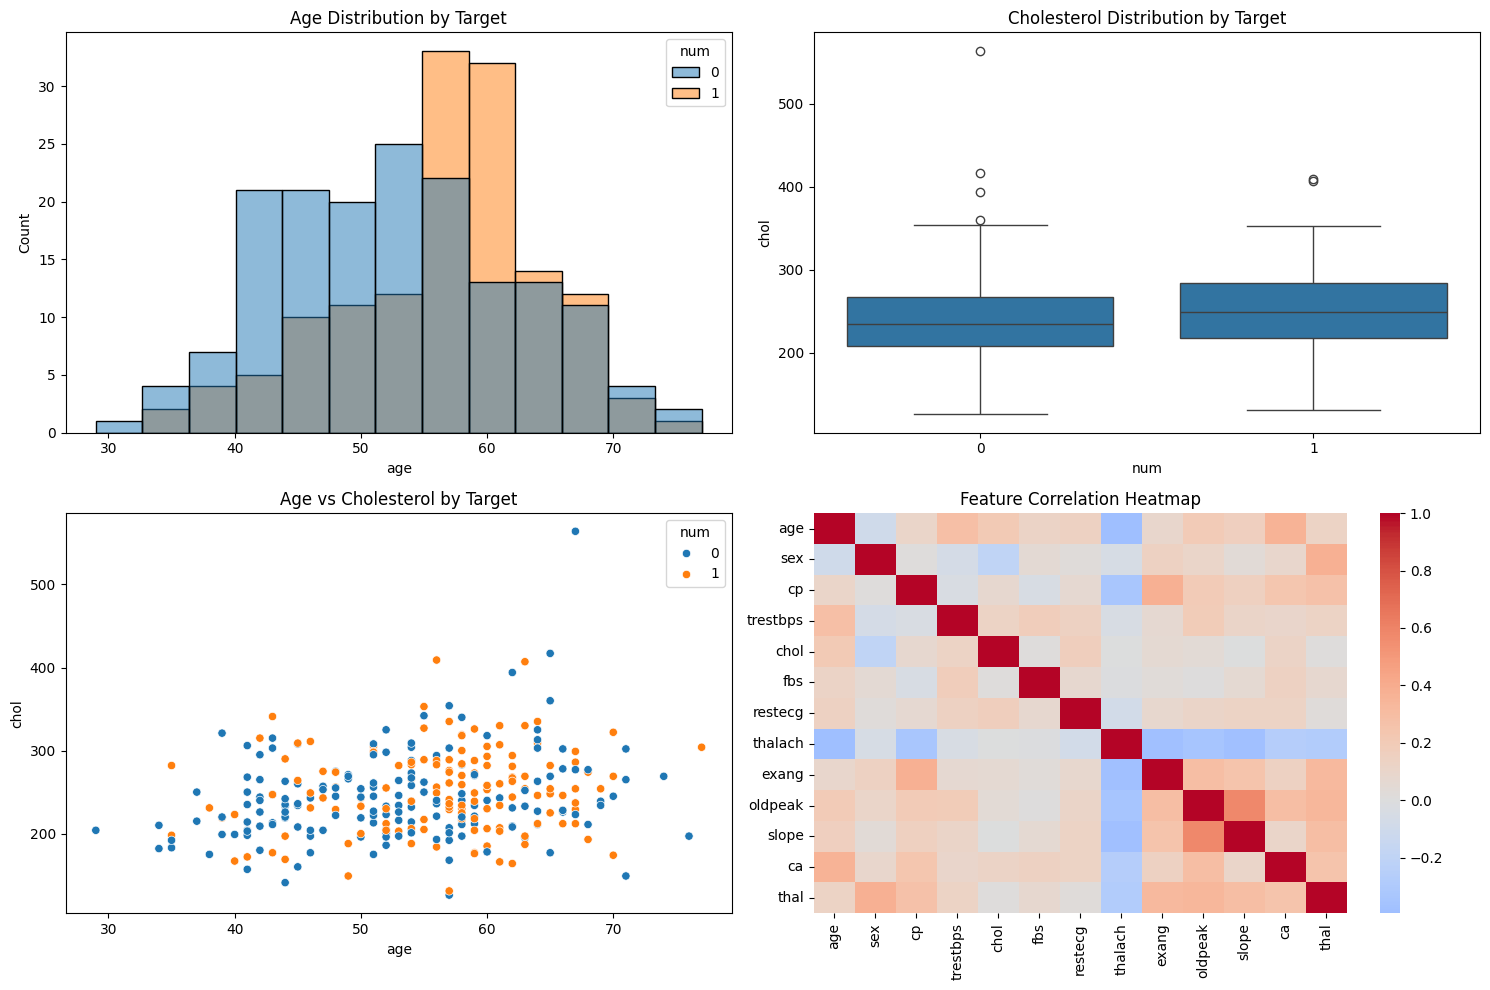

In [15]:
# Create visualization subplots
plt.figure(figsize=(15, 10))

# Histogram for age
plt.subplot(2, 2, 1)
sns.histplot(data=X, x='age', hue=y['num'])
plt.title('Age Distribution by Target')

# Box plot for cholesterol
plt.subplot(2, 2, 2)
sns.boxplot(data=X, y='chol', x=y['num'])
plt.title('Cholesterol Distribution by Target')

# Scatter plot of age vs cholesterol
plt.subplot(2, 2, 3)
sns.scatterplot(data=X, x='age', y='chol', hue=y['num'])
plt.title('Age vs Cholesterol by Target')

# Correlation heatmap
plt.subplot(2, 2, 4)
sns.heatmap(X.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

## Exercice 3

In [16]:
# Prepare data for modeling
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [19]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_cat = encoder.fit_transform(X[categorical_features])

# Get the correct feature names from the encoder
feature_names = []
for i, feature in enumerate(categorical_features):
    n_values = len(encoder.categories_[i]) - 1  # -1 because we dropped one category
    for j in range(n_values):
        feature_names.append(f"{feature}_{j+1}")

# Create DataFrame with correct column names
X_cat = pd.DataFrame(X_cat, columns=feature_names)

In [20]:

# Combine with numerical features
X_processed = pd.concat([X[numerical_features], X_cat], axis=1)


In [21]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y['num'], test_size=0.2, random_state=42
)


In [22]:

# Fit logistic regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)


/Users/alexs/PycharmProjects/ExplainableAI/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [25]:

# Evaluate model
y_pred = log_reg.predict(X_test)
print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred))



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [26]:

# Analyze coefficients
coef_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Coefficient': log_reg.coef_[0]
})
print("\nModel Coefficients:")
print(coef_df.sort_values('Coefficient', ascending=False))


Model Coefficients:
      Feature  Coefficient
16       ca_2     1.688119
15       ca_1     1.284054
20     thal_2     1.040492
5       sex_1     1.018193
8        cp_3     1.013326
13    slope_1     0.861935
17       ca_3     0.582052
4     oldpeak     0.484684
12    exang_1     0.394695
11  restecg_2     0.238617
6        cp_1     0.193288
21     thal_3     0.125960
1    trestbps     0.009262
2        chol     0.006024
9       fbs_1    -0.021343
0         age    -0.023499
3     thalach    -0.028643
10  restecg_1    -0.032068
19     thal_1    -0.173647
18       ca_4    -0.212946
14    slope_2    -0.230361
7        cp_2    -0.527577


## Exercice 4

In [27]:
# Fit decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

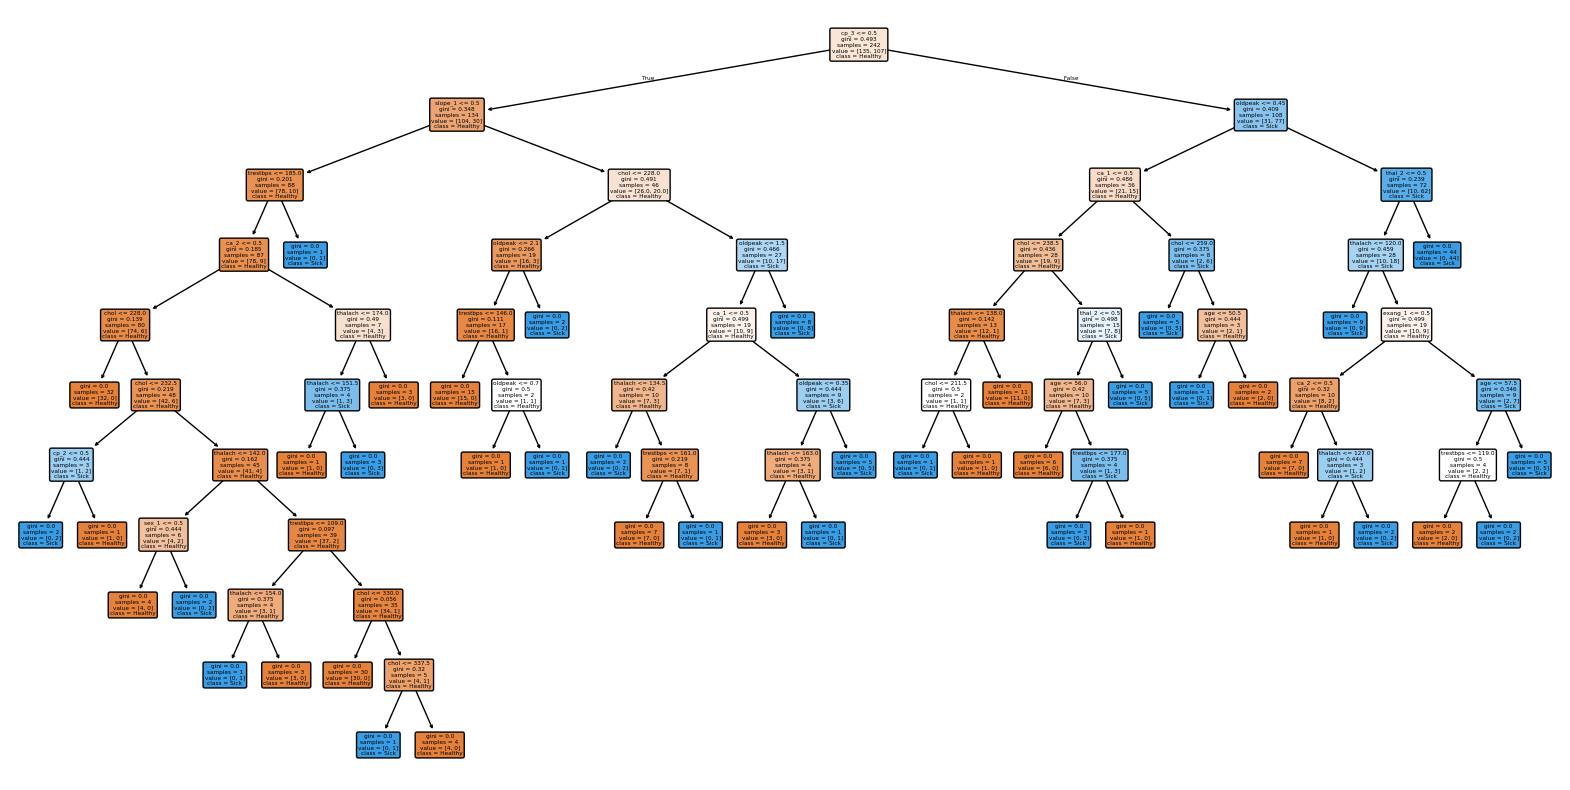

In [28]:

# Plot tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X_processed.columns, class_names=['Healthy', 'Sick'], 
          filled=True, rounded=True)
plt.show()


In [30]:

# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                         param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [31]:

# Best model evaluation
best_dt = grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)
print("\nDecision Tree Results:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        29
           1       0.77      0.72      0.74        32

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61



## Exercice 5

In [32]:
# Fit random forest
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [33]:

# Best model evaluation
best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))



Random Forest Results:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



In [34]:

# Feature importance
importance_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': best_rf.feature_importances_
})
print("\nFeature Importance:")
print(importance_df.sort_values('Importance', ascending=False))



Feature Importance:
      Feature  Importance
8        cp_3    0.143649
4     oldpeak    0.138059
20     thal_2    0.104881
3     thalach    0.104782
0         age    0.079176
13    slope_1    0.067364
2        chol    0.061774
1    trestbps    0.057827
12    exang_1    0.053401
16       ca_2    0.039236
5       sex_1    0.039065
7        cp_2    0.024997
15       ca_1    0.021304
17       ca_3    0.017462
11  restecg_2    0.013533
6        cp_1    0.010756
14    slope_2    0.007165
9       fbs_1    0.007145
19     thal_1    0.004289
21     thal_3    0.001982
18       ca_4    0.001815
10  restecg_1    0.000336


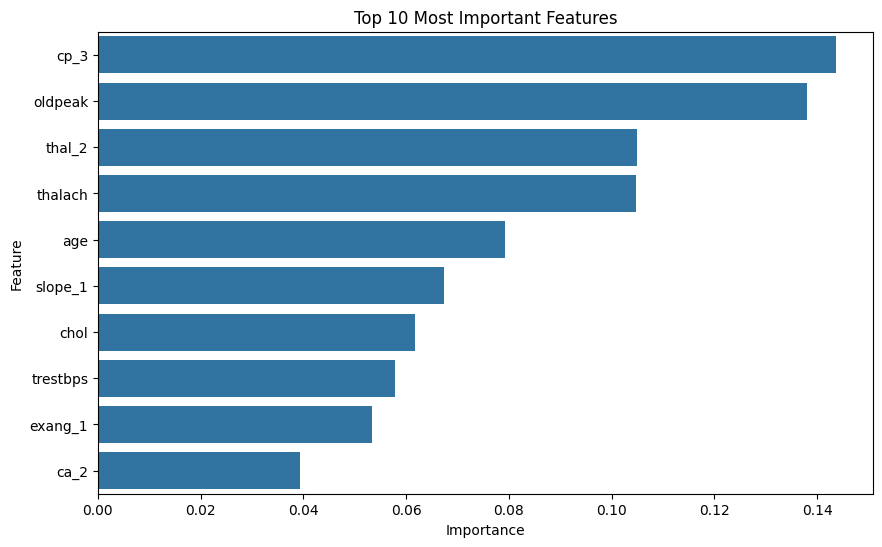

In [35]:

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.sort_values('Importance', ascending=False).head(10),
            x='Importance', y='Feature')
plt.title('Top 10 Most Important Features')
plt.show()